# Set Multi-cover with stochastic coverage requirements

In this notebook, we provide a description on how to reproduce experiments on the Set Multi-cover with stochastic coverage requirements.

## Dataset generation

First of all, we need to generate the problem instances. We use the same parameters specified in the Appendix but of course you can choose your own experimental configuration.

In [1]:
%load_ext autoreload
%autoreload 2
import os
# FIXME: bad code here...
# Run this cell only once to set the execution path in the main folder
os.chdir('..')

In [2]:
import numpy as np
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import shutil
import copy
from usecases.setcover.generate_instances import generate_training_and_test_sets, load_msc, MinSetCoverEnv
from usecases.setcover.stochastic_algorithm import StochasticAlgorithm, evaluate_stochastic_algo
from usecases.setcover.predict_then_optimize import PoissonNeuralNetwork, train_prob_regressor
from usecases.setcover.rl_train_and_test import train, test_rl_algo
from helpers.utility import my_wrap_experiment

c:\users\hp\documents\github\rl-offline-online-opt-experimental\venv\lib\site-packages\garage\experiment\deterministic.py:37: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  'Enabeling deterministic mode in PyTorch can have a performance '


In [62]:
# Min possible value for the Poisson rates
MIN_LMBD = 1
# Max possible value for the Poisson rates
MAX_LMBD = 10
# Number of products (elements)
NUM_PRODS = 200
# Number of sets (molds)
NUM_SETS = 1000
# Density of the availability matrix
DENSITY = 0.02
# Number of instances to generate
NUM_INSTANCES = 1000
# Seed to ensure reproducible results
SEED = 4
DATA_PATH = os.path.join('data',
                         'set-cover',
                         f'{NUM_PRODS}x{NUM_SETS}',
                         'linear',
                         f'{NUM_INSTANCES}-instances',
                         f'seed-{SEED}')

# Set the random seed to ensure reproducibility
np.random.seed(SEED)

In [63]:
# Generate training and test set in the specified directory
generate_training_and_test_sets(data_path=DATA_PATH,
                                num_instances=NUM_INSTANCES,
                                num_sets=NUM_SETS,
                                num_prods=NUM_PRODS,
                                density=DENSITY,
                                min_lmbd=MIN_LMBD,
                                max_lmbd=MAX_LMBD)

[MinSetCover] - True density: 0.01967
Saving instance 1/1000
Saving instance 2/1000
Saving instance 3/1000
Saving instance 4/1000
Saving instance 5/1000
Saving instance 6/1000
Saving instance 7/1000
Saving instance 8/1000
Saving instance 9/1000
Saving instance 10/1000
Saving instance 11/1000
Saving instance 12/1000
Saving instance 13/1000
Saving instance 14/1000
Saving instance 15/1000
Saving instance 16/1000
Saving instance 17/1000
Saving instance 18/1000
Saving instance 19/1000
Saving instance 20/1000
Saving instance 21/1000
Saving instance 22/1000
Saving instance 23/1000
Saving instance 24/1000
Saving instance 25/1000
Saving instance 26/1000
Saving instance 27/1000
Saving instance 28/1000
Saving instance 29/1000
Saving instance 30/1000
Saving instance 31/1000
Saving instance 32/1000
Saving instance 33/1000
Saving instance 34/1000
Saving instance 35/1000
Saving instance 36/1000
Saving instance 37/1000
Saving instance 38/1000
Saving instance 39/1000
Saving instance 40/1000
Saving inst

Saving instance 334/1000
Saving instance 335/1000
Saving instance 336/1000
Saving instance 337/1000
Saving instance 338/1000
Saving instance 339/1000
Saving instance 340/1000
Saving instance 341/1000
Saving instance 342/1000
Saving instance 343/1000
Saving instance 344/1000
Saving instance 345/1000
Saving instance 346/1000
Saving instance 347/1000
Saving instance 348/1000
Saving instance 349/1000
Saving instance 350/1000
Saving instance 351/1000
Saving instance 352/1000
Saving instance 353/1000
Saving instance 354/1000
Saving instance 355/1000
Saving instance 356/1000
Saving instance 357/1000
Saving instance 358/1000
Saving instance 359/1000
Saving instance 360/1000
Saving instance 361/1000
Saving instance 362/1000
Saving instance 363/1000
Saving instance 364/1000
Saving instance 365/1000
Saving instance 366/1000
Saving instance 367/1000
Saving instance 368/1000
Saving instance 369/1000
Saving instance 370/1000
Saving instance 371/1000
Saving instance 372/1000
Saving instance 373/1000


Saving instance 663/1000
Saving instance 664/1000
Saving instance 665/1000
Saving instance 666/1000
Saving instance 667/1000
Saving instance 668/1000
Saving instance 669/1000
Saving instance 670/1000
Saving instance 671/1000
Saving instance 672/1000
Saving instance 673/1000
Saving instance 674/1000
Saving instance 675/1000
Saving instance 676/1000
Saving instance 677/1000
Saving instance 678/1000
Saving instance 679/1000
Saving instance 680/1000
Saving instance 681/1000
Saving instance 682/1000
Saving instance 683/1000
Saving instance 684/1000
Saving instance 685/1000
Saving instance 686/1000
Saving instance 687/1000
Saving instance 688/1000
Saving instance 689/1000
Saving instance 690/1000
Saving instance 691/1000
Saving instance 692/1000
Saving instance 693/1000
Saving instance 694/1000
Saving instance 695/1000
Saving instance 696/1000
Saving instance 697/1000
Saving instance 698/1000
Saving instance 699/1000
Saving instance 700/1000
Saving instance 701/1000
Saving instance 702/1000


Saving instance 996/1000
Saving instance 997/1000
Saving instance 998/1000
Saving instance 999/1000
Saving instance 1000/1000


We can find the saved instances in the `DATA_PATH` folder.

## Stochastic algorithm

In this section, we compute the results for the Sample Average Approximation algorithm.

In [6]:
# Min possible value for the Poisson rates
MIN_LMBD = 1
# Max possible value for the Poisson rates
MAX_LMBD = 10
# Number of products (elements)
NUM_PRODS = 200
# Number of sets (molds)
NUM_SETS = 1000
# Density of the availability matrix
DENSITY = 0.02
# Number of instances to generate
NUM_INSTANCES = 1000
# Number of scenarios used for the stochastic algorithm
NUM_SCENARIOS = [10, 20, 30, 50, 75, 100]
# Number of instances used for the evaluation
NUM_EVALUATED_INSTANCES = 50
# Fraction of the instances used for test
TEST_SPLIT = 0.5
# Seed to ensure reproducible results
SEED = 0
DATA_PATH = os.path.join('data',
                         'set-cover',
                         f'{NUM_PRODS}x{NUM_SETS}',
                         'linear',
                         f'{NUM_INSTANCES}-instances',
                         f'seed-{SEED}')
LOG_DIR = os.path.join('tmp',
                       'results',
                       'set-cover',
                       'stochastic',
                       'poisson',
                       'train-test-split')
LOG_DIR = os.path.join(LOG_DIR,
                       'stochastic-algo',
                       'mean',
                       f'{NUM_PRODS}x{NUM_SETS}',
                       'linear',
                       f'{NUM_INSTANCES}-instances',
                       f'seed-{SEED}')

# The maximum number of allowed scenarios is training set size
assert max(NUM_SCENARIOS) <= int(NUM_INSTANCES * (1 - TEST_SPLIT)), \
    "The maximum number of allowed scenarios is training set size"

# Set the random seed to ensure reproducibility
np.random.seed(SEED)

In [7]:
# Load the instances
instances = list()
optimal_costs = list()

print('Loading instances...')
for f in os.listdir(DATA_PATH):
    if os.path.isdir(os.path.join(DATA_PATH, f)):
        instances.append(load_msc(os.path.join(DATA_PATH, f, 'instance.pkl')))
        optimal_cost = pickle.load(open(os.path.join(DATA_PATH, f, 'optimal-cost.pkl'), 'rb'))
        optimal_costs.append(optimal_cost)
print('Finished')

Loading instances...
Finished


In [8]:
# Split between training and test instances
train_instances, test_instances, \
    train_optimal_costs, test_optimal_costs = \
        train_test_split(instances, optimal_costs, test_size=TEST_SPLIT, random_state=SEED)

In [9]:
for num_scenarios in NUM_SCENARIOS:
    log_dir = os.path.join(LOG_DIR,
                           f'{num_scenarios}-scenarios')

    # Remove the logging folder
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    else:
        shutil.rmtree(log_dir)
        os.makedirs(log_dir)

    # Create the stochastic algorithm instance and solve the problem
    instance = StochasticAlgorithm(instances=train_instances, num_scenarios=num_scenarios)
    res = instance.solve()
    pickle.dump(res, open(os.path.join(log_dir, 'res.pkl'), 'wb'))

    # Evaluate the results on training set
    print('\nTRAINING SET')
    evaluate_stochastic_algo(res=LOG_DIR,
                             num_scenarios=num_scenarios,
                             instances=train_instances,
                             optimal_costs=train_optimal_costs)

    # Evaluate the results on test set
    print('TEST SET')
    evaluate_stochastic_algo(res=LOG_DIR,
                             num_scenarios=num_scenarios,
                             instances=test_instances[:NUM_EVALUATED_INSTANCES],
                             optimal_costs=test_optimal_costs)

    print()

[Stochastic algorithm] - Scenario: 0
[Stochastic algorithm] - Scenario: 1
[Stochastic algorithm] - Scenario: 2
[Stochastic algorithm] - Scenario: 3
[Stochastic algorithm] - Scenario: 4
[Stochastic algorithm] - Scenario: 5
[Stochastic algorithm] - Scenario: 6
[Stochastic algorithm] - Scenario: 7
[Stochastic algorithm] - Scenario: 8
[Stochastic algorithm] - Scenario: 9
[Stochastic algorithm] Starting optimization...
[Stochastic algorithm] Optimization finished - Elapsed: 0.7856540679931641

TRAINING SET
[Stochastic algorithm] Num. scenarios: 10 | Mean optimal cost: 7154.316 | Stochastic algorithm mean cost: 41238.0

-----------------------------------------------------------------------------------------------------------------

TEST SET
[Stochastic algorithm] Num. scenarios: 10 | Mean optimal cost: 7019.516 | Stochastic algorithm mean cost: 40086.4

-----------------------------------------------------------------------------------------------------------------


[Stochastic algorithm] 

[Stochastic algorithm] - Scenario: 44
[Stochastic algorithm] - Scenario: 45
[Stochastic algorithm] - Scenario: 46
[Stochastic algorithm] - Scenario: 47
[Stochastic algorithm] - Scenario: 48
[Stochastic algorithm] - Scenario: 49
[Stochastic algorithm] - Scenario: 50
[Stochastic algorithm] - Scenario: 51
[Stochastic algorithm] - Scenario: 52
[Stochastic algorithm] - Scenario: 53
[Stochastic algorithm] - Scenario: 54
[Stochastic algorithm] - Scenario: 55
[Stochastic algorithm] - Scenario: 56
[Stochastic algorithm] - Scenario: 57
[Stochastic algorithm] - Scenario: 58
[Stochastic algorithm] - Scenario: 59
[Stochastic algorithm] - Scenario: 60
[Stochastic algorithm] - Scenario: 61
[Stochastic algorithm] - Scenario: 62
[Stochastic algorithm] - Scenario: 63
[Stochastic algorithm] - Scenario: 64
[Stochastic algorithm] - Scenario: 65
[Stochastic algorithm] - Scenario: 66
[Stochastic algorithm] - Scenario: 67
[Stochastic algorithm] - Scenario: 68
[Stochastic algorithm] - Scenario: 69
[Stochastic 

KeyboardInterrupt: 

## Predict-then-optimize

In this section, we train a probabilistic regressor model and use it in a "Predict-then-optimize" fashion: the model will predict the Poisson rates which are then plugged in the downstream stochastic optimization model.

If you want to prove that UNIFY can generalize Decision Focused Learning approaches ("Generalization of DFL paragraph" of the "Empirical Evaluation" section) use a single scenario in the optimization algorithm. Otherwise you can set a variable number of scenarios (see "Stochastic Optimization" paragraph of "Empirical Evaluation" section).

In [21]:
# Seed to reproduce results
SEED = 0
# Number of products of Set Multi-cover instances
NUM_PRODS = 200
# Number of sets of Set Multi-cover instances
NUM_SETS = 1000
# Number of instances to load
NUM_INSTANCES = 1000
# Number of instances to evaluate
NUM_EVALUATED_INSTANCES = 50
# Fraction of the instances used for the evaluation
TEST_SPLIT = 0.5
# True if you want to train the model; False to load an existing model
TRAIN = False
# If you want to prove that CPR can generalize Decision Focused Learning approaches ("Generalization of DFL paragraph" 
# of the "Empirical Evaluation" section) use a single scenario in the optimization algorithm. 
# Otherwise you can set a variable number of scenarios (see "Low price solutions for stochastic optimization problems" 
# paragraph of "Empirical Evaluation" section)
NUM_SCENARIOS = [1]
NUM_SCENARIOS = [10, 20, 30, 50, 75, 100]
DATA_PATH = os.path.join('data',
                         'set-cover',
                         f'{NUM_PRODS}x{NUM_SETS}',
                         'linear',
                         f'{NUM_INSTANCES}-instances',
                         f'seed-{SEED}')
MODEL_SAVEPATH = os.path.join('tmp',
                              'probabilistic-models',
                              'set-cover',
                              f'{NUM_PRODS}x{NUM_SETS}',
                              'linear',
                              f'{NUM_INSTANCES}-instances',
                              f'seed-{SEED}')

LOG_DIR = os.path.join('results',
                       'set-cover',
                       'stochastic',
                       'poisson',
                       'train-test-split',
                       'predict-then-optimize',
                       f'{NUM_PRODS}x{NUM_SETS}',
                       'linear',
                       f'{NUM_INSTANCES}-instances',
                       f'seed-{SEED}')
print(DATA_PATH)

data\set-cover\200x1000\linear\1000-instances\seed-0


In [25]:
# Create the model savepath if it does not exist
if not os.path.exists(MODEL_SAVEPATH):
    os.makedirs(MODEL_SAVEPATH)
    
# Create the results path if it does not exist
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

# Set the random seed to ensure reproducibility
np.random.seed(SEED)

In [26]:
# Create the probabilistic regressor
model = PoissonNeuralNetwork(input_shape=(1, ), output_shape=NUM_PRODS)

In [27]:
# Train the probabilistic regressor from scratch or load it from file
if TRAIN:
    model = train_prob_regressor(data_path=DATA_PATH,
                                 num_prods=NUM_PRODS,
                                 test_split=TEST_SPLIT,
                                 seed=SEED,
                                 model_savepath=MODEL_SAVEPATH)
else:
    model.load(MODEL_SAVEPATH)

In [28]:
# Load the instances
instances = list()
optimal_costs = list()

print('Loading instances...')
for f in os.listdir(DATA_PATH):
    if os.path.isdir(os.path.join(DATA_PATH, f)):
        instances.append(load_msc(os.path.join(DATA_PATH, f, 'instance.pkl')))
        optimal_cost = pickle.load(open(os.path.join(DATA_PATH, f, 'optimal-cost.pkl'), 'rb'))
        optimal_costs.append(optimal_cost)
print('Finished')

Loading instances...
Finished


In [29]:
# Split between training and test instances
train_instances, test_instances, \
    _, test_optimal_costs = \
        train_test_split(instances, optimal_costs, test_size=TEST_SPLIT, random_state=SEED)

In [30]:
# Evaluate the probabilistic model
test_obs = np.asarray([inst.observables for inst in test_instances])
test_obs = np.expand_dims(test_obs, axis=1)
test_lambdas = np.asarray([inst.lmbds for inst in test_instances])

preds = model(test_obs)
lmbds_hat = preds.rate.numpy()
mapes = list()
for i in range(NUM_PRODS):
    mape = mean_absolute_percentage_error(lmbds_hat[:, i], test_lambdas[:, i])
    mapes.append(mape)

mapes = np.asarray(mapes)
np.save(os.path.join(LOG_DIR, 'mapes'), mapes)

print(f'Max MAE: {np.max(mapes)} | Min MAE: {np.min(mapes)} | Mean MAE: {np.mean(mapes)}')

Max MAE: 0.015281820584395296 | Min MAE: 0.00013323625606616828 | Mean MAE: 0.005202231239029212


In [31]:
# Keep track of runtimes and cost grouped by number of scenarios
runtimes = dict()
costs = dict()

# Iterate over all the test instances and evaluate the predict-then-optimize approach
for inst_idx, inst in enumerate(test_instances[:NUM_EVALUATED_INSTANCES]):

    # Observable for the current instance
    obs = inst.observables
    # FIXME: we assume the observation to be univariate
    obs = np.array([[obs]])

    # These are the instances sampled from the ML model and given as input to the stochastic method
    train_instances = list()
    for idx in range(max(NUM_SCENARIOS)):

        msc_copy = copy.deepcopy(inst)
        poisson = model(obs)
        # The impose the first scenario to have demands equal to the Poisson rates
        if idx == 0:
            rates = poisson.rate.numpy()
            demands = rates.astype(dtype=np.int32)
        else:
            demands = poisson.sample().numpy()
        demands = np.squeeze(demands)
        msc_copy.demands = demands
        train_instances.append(msc_copy)

    # Apply the stochastic algo with the user defined number of scenarios
    for num_scenarios in NUM_SCENARIOS:
        if num_scenarios not in runtimes.keys():
            runtimes[num_scenarios] = list()
        if num_scenarios not in costs.keys():
            costs[num_scenarios] = list()

        # Create the stochastic algorithm instance and solve the problem
        instance = StochasticAlgorithm(instances=train_instances, num_scenarios=num_scenarios)
        res = instance.solve()
        runtimes[num_scenarios].append(res['Runtime'])

        # Evaluate the solution found on the current instance
        print(f'[Predict-then-optimize] Results for instance n. {inst_idx+1}/{NUM_EVALUATED_INSTANCES}')
        res = evaluate_stochastic_algo(res=res,
                                       num_scenarios=num_scenarios,
                                       instances=[inst],
                                       optimal_costs=test_optimal_costs)

        costs[num_scenarios].append(res['Stochastic algo mean cost'])

[Stochastic algorithm] - Scenario: 0
[Stochastic algorithm] - Scenario: 1
[Stochastic algorithm] - Scenario: 2
[Stochastic algorithm] - Scenario: 3
[Stochastic algorithm] - Scenario: 4
[Stochastic algorithm] - Scenario: 5
[Stochastic algorithm] - Scenario: 6
[Stochastic algorithm] - Scenario: 7
[Stochastic algorithm] - Scenario: 8
[Stochastic algorithm] - Scenario: 9
[Stochastic algorithm] Starting optimization...
[Stochastic algorithm] Optimization finished - Elapsed: 0.9235038757324219
[Predict-then-optimize] Results for instance n. 1/50
[Stochastic algorithm] Num. scenarios: 10 | Mean optimal cost: 7019.516 | Stochastic algorithm mean cost: 25629.0

-----------------------------------------------------------------------------------------------------------------

[Stochastic algorithm] - Scenario: 0
[Stochastic algorithm] - Scenario: 1
[Stochastic algorithm] - Scenario: 2
[Stochastic algorithm] - Scenario: 3
[Stochastic algorithm] - Scenario: 4
[Stochastic algorithm] - Scenario: 5
[S

KeyboardInterrupt: 

In [22]:
# Save results on file
# Remove the logging folder if exists or create it
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
else:
    shutil.rmtree(LOG_DIR)
    os.makedirs(LOG_DIR)

pickle.dump(runtimes, open(os.path.join(LOG_DIR, 'runtimes.pkl'), 'wb'))
pickle.dump(costs, open(os.path.join(LOG_DIR, 'costs.pkl'), 'wb'))

## Generalization of DFL

In this section, we will train and test our UNIFY as a DFL method.

In [43]:
# Seed to reproduce results
SEED = 0
# Number of products of Set Multi-cover instances
NUM_PRODS = 200
# Number of sets of Set Multi-cover instances
NUM_SETS = 1000
# Number of instances to load
NUM_INSTANCES = 1000
# Number of instances to evaluate
NUM_EVALUATED_INSTANCES = 50
# Fraction of the instances used for the evaluation
TEST_SPLIT = 0.5
# True if you want to train the model; False to load an existing model
TRAIN = True
# Batch size
BATCH_SIZE = 100
# Number of epochs
EPOCHS = 10000

SAVEPATH_PREFIX = os.path.join('results',
                               'set-cover',
                               'stochastic',
                               'poisson',
                               'train-test-split',
                               'rl',
                               f'{NUM_PRODS}x{NUM_SETS}',
                               'linear',
                               f'{NUM_INSTANCES}-instances',
                               f'seed-{SEED}')
DATA_PATH = os.path.join('data',
                         'set-cover',
                         f'{NUM_PRODS}x{NUM_SETS}',
                         'linear',
                         f'{NUM_INSTANCES}-instances',
                         f'seed-{SEED}')

# Set the random seed to ensure reproducibility
np.random.seed(SEED)

In [39]:
# Create the environment
env = MinSetCoverEnv(num_prods=NUM_PRODS,
                     num_sets=NUM_SETS,
                     instances_filepath=DATA_PATH,
                     seed=SEED)

[MinSetCoverEnv] - Loading instances...
[MinSetCoverEnv] - Finished


In [40]:
# Create the saving directory if it does not exist
if not os.path.exists(SAVEPATH_PREFIX):
    os.makedirs(SAVEPATH_PREFIX)

In [41]:
# Train and test the RL algo
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
if TRAIN:
    run = my_wrap_experiment(train,
                             logging_dir=SAVEPATH_PREFIX,
                             snapshot_mode='gap_overwrite',
                             snapshot_gap=EPOCHS // 10,
                             # FIXME: archive_launch_repo=True is not supported
                             archive_launch_repo=False)
    run(num_epochs=EPOCHS, batch_size=BATCH_SIZE, env=env)

2023-03-28 17:18:03 | [train] [train] Logging to tmp\results\set-cover\stochastic\poisson\train-test-split\rl\200x1000\linear\1000-instances\seed-0
2023-03-28 17:18:03 | [train] [train] Logging to tmp\results\set-cover\stochastic\poisson\train-test-split\rl\200x1000\linear\1000-instances\seed-0


c:\users\hp\documents\github\rl-offline-online-opt-experimental\venv\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\hp\documents\github\rl-offline-online-opt-experimental\venv\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


2023-03-28 17:18:07 | [train] [train] Obtaining samples...
2023-03-28 17:18:07 | [train] [train] Obtaining samples...
2023-03-28 17:18:10 | [train] [train] epoch #0 | Optimizing policy...
2023-03-28 17:18:10 | [train] [train] epoch #0 | Optimizing policy...
2023-03-28 17:18:10 | [train] [train] epoch #0 | Computing loss before
2023-03-28 17:18:10 | [train] [train] epoch #0 | Computing loss before
2023-03-28 17:18:10 | [train] [train] epoch #0 | Computing KL before
2023-03-28 17:18:10 | [train] [train] epoch #0 | Computing KL before
2023-03-28 17:18:10 | [train] [train] epoch #0 | Optimizing
2023-03-28 17:18:10 | [train] [train] epoch #0 | Optimizing
Optimizing minibatches
2023-03-28 17:18:10 | [train] [train] epoch #0 | Computing KL after
2023-03-28 17:18:10 | [train] [train] epoch #0 | Computing KL after
2023-03-28 17:18:10 | [train] [train] epoch #0 | Computing loss after
2023-03-28 17:18:10 | [train] [train] epoch #0 | Computing loss after
2023-03-28 17:18:10 | [train] [train] epoch

KeyboardInterrupt: 

In [44]:
test_rl_algo(SAVEPATH_PREFIX, env, num_episodes=NUM_EVALUATED_INSTANCES)

c:\users\hp\documents\github\rl-offline-online-opt-experimental\venv\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
c:\users\hp\documents\github\rl-offline-online-opt-experimental\venv\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\hp\documents\github\rl-offline-online-opt-experimental\venv\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.w

Training instances - Episode 1/500
Episode reward: 9337.0
Runtime: 0.06486678123474121
Training instances - Episode 2/500
Episode reward: 15400.0
Runtime: 0.03353404998779297
Training instances - Episode 3/500
Episode reward: 9696.0
Runtime: 0.02725839614868164
Training instances - Episode 4/500
Episode reward: 9685.0
Runtime: 0.029084205627441406
Training instances - Episode 5/500
Episode reward: 20935.0
Runtime: 0.04839897155761719
Training instances - Episode 6/500
Episode reward: 8594.0
Runtime: 0.03240561485290527
Training instances - Episode 7/500
Episode reward: 7677.0
Runtime: 0.03195524215698242
Training instances - Episode 8/500
Episode reward: 7126.0
Runtime: 0.03113532066345215
Training instances - Episode 9/500
Episode reward: 6389.0
Runtime: 0.043460845947265625
Training instances - Episode 10/500
Episode reward: 11699.0
Runtime: 0.028550148010253906
Training instances - Episode 11/500
Episode reward: 12553.0
Runtime: 0.042206525802612305
Training instances - Episode 12/5

Episode reward: 7292.0
Runtime: 0.05584430694580078
Training instances - Episode 96/500
Episode reward: 34314.0
Runtime: 0.02797532081604004
Training instances - Episode 97/500
Episode reward: 29458.0
Runtime: 0.02169489860534668
Training instances - Episode 98/500
Episode reward: 6775.0
Runtime: 0.021006345748901367
Training instances - Episode 99/500
Episode reward: 5400.0
Runtime: 0.02291107177734375
Training instances - Episode 100/500
Episode reward: 17542.0
Runtime: 0.02409982681274414
Training instances - Episode 101/500
Episode reward: 21215.0
Runtime: 0.04536318778991699
Training instances - Episode 102/500
Episode reward: 12434.0
Runtime: 0.038247108459472656
Training instances - Episode 103/500
Episode reward: 10582.0
Runtime: 0.02705216407775879
Training instances - Episode 104/500
Episode reward: 6616.0
Runtime: 0.03320717811584473
Training instances - Episode 105/500
Episode reward: 14777.0
Runtime: 0.04062080383300781
Training instances - Episode 106/500
Episode reward: 

Episode reward: 17190.0
Runtime: 0.03846430778503418
Training instances - Episode 194/500
Episode reward: 14220.0
Runtime: 0.03500556945800781
Training instances - Episode 195/500
Episode reward: 6775.0
Runtime: 0.02898406982421875
Training instances - Episode 196/500
Episode reward: 10193.0
Runtime: 0.031244277954101562
Training instances - Episode 197/500
Episode reward: 19180.0
Runtime: 0.03301405906677246
Training instances - Episode 198/500
Episode reward: 30157.0
Runtime: 0.028981685638427734
Training instances - Episode 199/500
Episode reward: 15551.0
Runtime: 0.02444171905517578
Training instances - Episode 200/500
Episode reward: 23608.0
Runtime: 0.040860891342163086
Training instances - Episode 201/500
Episode reward: 17228.0
Runtime: 0.026621580123901367
Training instances - Episode 202/500
Episode reward: 10361.0
Runtime: 0.030514001846313477
Training instances - Episode 203/500
Episode reward: 8903.0
Runtime: 0.025002479553222656
Training instances - Episode 204/500
Episod

Episode reward: 12696.0
Runtime: 0.02918720245361328
Training instances - Episode 290/500
Episode reward: 14764.0
Runtime: 0.03042316436767578
Training instances - Episode 291/500
Episode reward: 6336.0
Runtime: 0.022991180419921875
Training instances - Episode 292/500
Episode reward: 6224.0
Runtime: 0.03194403648376465
Training instances - Episode 293/500
Episode reward: 7864.0
Runtime: 0.02713942527770996
Training instances - Episode 294/500
Episode reward: 15255.0
Runtime: 0.02255535125732422
Training instances - Episode 295/500
Episode reward: 16877.0
Runtime: 0.02644658088684082
Training instances - Episode 296/500
Episode reward: 7356.0
Runtime: 0.02611851692199707
Training instances - Episode 297/500
Episode reward: 7598.0
Runtime: 0.021996259689331055
Training instances - Episode 298/500
Episode reward: 14586.0
Runtime: 0.02800607681274414
Training instances - Episode 299/500
Episode reward: 5952.0
Runtime: 0.03236508369445801
Training instances - Episode 300/500
Episode reward

Episode reward: 17130.0
Runtime: 0.040282487869262695
Training instances - Episode 383/500
Episode reward: 19541.0
Runtime: 0.02955341339111328
Training instances - Episode 384/500
Episode reward: 8995.0
Runtime: 0.028003454208374023
Training instances - Episode 385/500
Episode reward: 14628.0
Runtime: 0.04879474639892578
Training instances - Episode 386/500
Episode reward: 10424.0
Runtime: 0.025214195251464844
Training instances - Episode 387/500
Episode reward: 17031.0
Runtime: 0.02761363983154297
Training instances - Episode 388/500
Episode reward: 13325.0
Runtime: 0.03130745887756348
Training instances - Episode 389/500
Episode reward: 18909.0
Runtime: 0.027489662170410156
Training instances - Episode 390/500
Episode reward: 8264.0
Runtime: 0.0339052677154541
Training instances - Episode 391/500
Episode reward: 14581.0
Runtime: 0.027996301651000977
Training instances - Episode 392/500
Episode reward: 20368.0
Runtime: 0.02714681625366211
Training instances - Episode 393/500
Episode 

Episode reward: 19524.0
Runtime: 0.037360191345214844
Training instances - Episode 480/500
Episode reward: 14307.0
Runtime: 0.023329973220825195
Training instances - Episode 481/500
Episode reward: 8281.0
Runtime: 0.02817702293395996
Training instances - Episode 482/500
Episode reward: 11596.0
Runtime: 0.03316640853881836
Training instances - Episode 483/500
Episode reward: 7985.0
Runtime: 0.021953105926513672
Training instances - Episode 484/500
Episode reward: 18551.0
Runtime: 0.02725839614868164
Training instances - Episode 485/500
Episode reward: 14412.0
Runtime: 0.02822566032409668
Training instances - Episode 486/500
Episode reward: 11736.0
Runtime: 0.033067941665649414
Training instances - Episode 487/500
Episode reward: 13642.0
Runtime: 0.029191017150878906
Training instances - Episode 488/500
Episode reward: 10376.0
Runtime: 0.03183269500732422
Training instances - Episode 489/500
Episode reward: 15311.0
Runtime: 0.03568148612976074
Training instances - Episode 490/500
Episode

## Visualize results

Let's plot the figure that are shown in the paper.

### Figure 4 and 5

In [45]:
from usecases.setcover.plotting import plot_rl_pto_evaluation, plot_pto_evaluation

In [46]:
NUM_INSTANCES = 1000

`data_path` is the prefix of the folder containing the instances. `seed` is the seed used to ensure reproducibility. The full data path is `data/set-cover/200x1000/linear/seed-{seed}`.

`pto_res_dir` is the prefix of the the folder with the Predict-then-optimize results. We expect a `single-scenario` subdirectory to be there. The full path is `results/set-cover/stochastic/poisson/train-test-split/predict-then-optimize/200x1000/linear/{num_instances}-instances/single-scenario/seed-{seed}`. A file `costs.pkl` must be there.

`rl_res_dir` is the prefix of the folder with the CPR results. The full path is `results/set-cover/stochastic/poisson/train-test-split/rl/200x1000/linear/{num_instances}-instances/'seed-{seed}`. A `test-set-res.pkl` is expected to be there.

Loading instances...
Finished
TEST SET
Mean optimal cost: 7019.516 | Mean RL cost: 12929.26 | Mean Predict-then-optimize: 164835.054


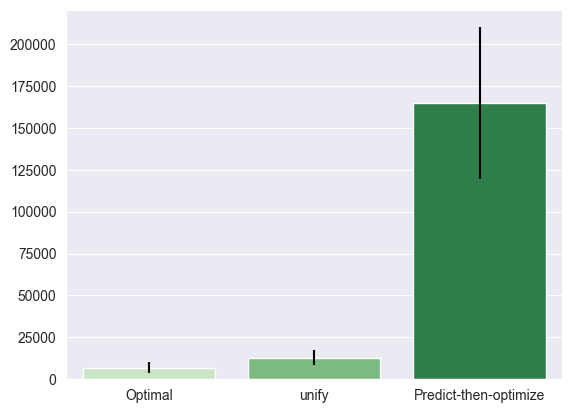

In [65]:
plot_rl_pto_evaluation(data_path='data/set-cover/200x1000/linear/',
                           pto_res_dir='results/set-cover/stochastic/poisson/train-test-split/predict-then-optimize/200x1000/linear/',
                           rl_res_dir='results/set-cover/stochastic/poisson/train-test-split/rl/200x1000/linear/',
                           num_instances=NUM_INSTANCES,
                           seed=0,
                           test_split=0.5,
                           acronym='unify')

Loading instances...
Finished
[Stochastic algorithm] Num. scenarios: 10 | Mean optimal cost: 8527.46 | Stochastic algorithm mean cost: 51780.0

----------------------------------------------------------------------------------------------------------------

Predict-then-optimize mean cost: 3.7257002671369905 | Predict-then-optimize mean runtime: 22.535107086433605
Stochastic algorithm mean cost: 6.072148095681482
RL mean cost: 1.9664408862662506
[Stochastic algorithm] Num. scenarios: 20 | Mean optimal cost: 8527.46 | Stochastic algorithm mean cost: 43247.2

----------------------------------------------------------------------------------------------------------------

Predict-then-optimize mean cost: 2.4827768174814073 | Predict-then-optimize mean runtime: 44.759899285880465
Stochastic algorithm mean cost: 5.071521883421323
RL mean cost: 1.9664408862662506
[Stochastic algorithm] Num. scenarios: 30 | Mean optimal cost: 8527.46 | Stochastic algorithm mean cost: 28988.4

----------------

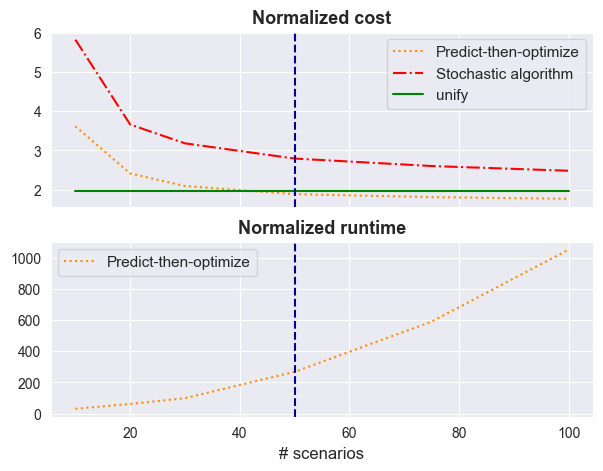

In [66]:
plot_pto_evaluation(data_path='data/set-cover/200x1000/linear/',
                    stochastic_algo_res_dir='results/set-cover/stochastic/poisson/train-test-split/stochastic-algo/mean/200x1000/linear/',
                    pto_res_dir='results/set-cover/stochastic/poisson/train-test-split/predict-then-optimize/200x1000/linear/',
                    rl_res_dir='results/set-cover/stochastic/poisson/train-test-split/rl/200x1000/linear/',
                    seed=[1, 2, 3, 4],
                    num_instances=NUM_INSTANCES,
                    test_split=0.5,
                    acronym='unify')